## Predict price at next period with LSTM and Keras as a regression


In [101]:
import sys
import time
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY

import mysql.connector
from mysql.connector import errorcode

import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, normalize, scale

print(tf.__version__)
print(sys.version)

# https://mapr.com/blog/deep-learning-tensorflow/


1.0.0
3.5.4 |Anaconda custom (x86_64)| (default, Sep 21 2017, 18:03:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [102]:
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

from ittutils import ittconnection, get_resampled, get_raw_price, get_raw_volume

### Get price and volume timeseries from Staging DB 


In [103]:
db_connection = ittconnection('prodcopy')

transaction_coin = 'ETH'
counter_coin = 0
resample_period = 60

raw_price_ts = get_raw_price(db_connection, transaction_coin, counter_coin)
raw_volume_ts = get_raw_volume(db_connection, transaction_coin, counter_coin)

raw_price_ts["volume"] = raw_volume_ts



In [104]:
raw_price_ts.tail(5)


,price,volume
timestamp,,
2018-03-12 07:38:01.954350,7574314,1209.077677
2018-03-12 07:39:04.370770,7562996,1209.079502
2018-03-12 07:40:06.445440,7574316,1209.094639
2018-03-12 07:41:08.812360,7574316,1209.095969
2018-03-12 07:42:11.047110,7574316,1209.101274


### Cut the bad data from the beginning + resample

In [105]:
price_ts = raw_price_ts  # remove gaps
price_ts[pd.isnull(price_ts["price"])] = None

# resample (for smoothing) and normalize (for learning)
price_ts = price_ts.resample(rule='15min').mean()


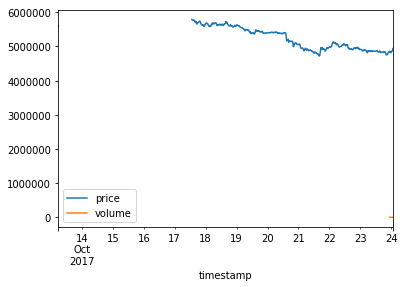

In [106]:
cutoff=1040
price_ts.head(cutoff).plot()


In [107]:
# cut empty ts from the beginning and interpolate the rest
price_ts = price_ts.tail(len(price_ts)-cutoff)
price_ts = price_ts.interpolate() 


In [108]:
price_ts.min(axis=0)


price     2.395878e+06
volume    8.641357e+02
dtype: float64

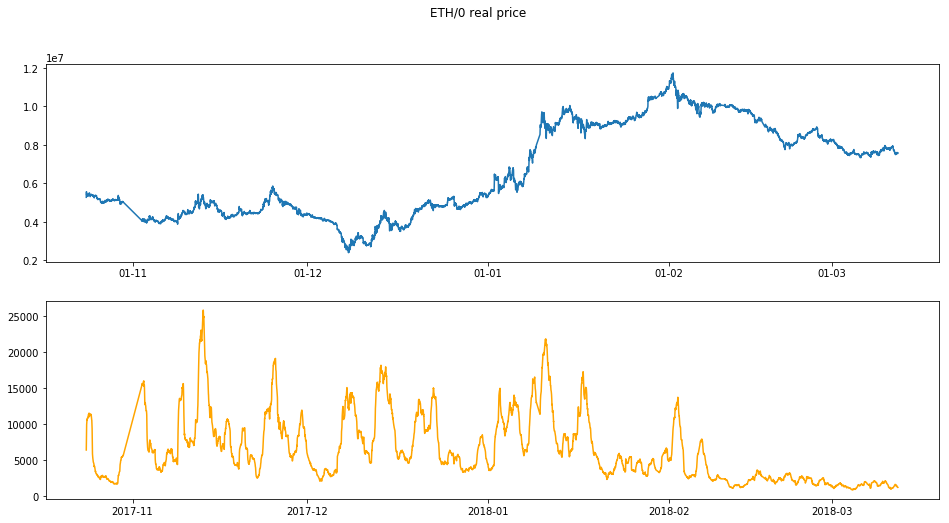

In [109]:
# visually inspect the price and volume
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
fig.suptitle("%s/%d real price" % (transaction_coin, counter_coin))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax1.plot(price_ts['price'])
ax2.plot(price_ts['volume'], color='orange')
plt.show()


In [110]:
#print(resampl_ts.shape)
print(price_ts.shape)


(13369, 2)


## Helper functions to convert ts into dataset

In [111]:

# REGRESSION: dataset for regression: split one continues timeseries inro many subsets by striding
def regression_dataset_from_ts(data_df, win_size, stride, future, label_type):

    n = len(data_df)
    num_examples = int((n-win_size)/stride)
    
    # (4968, 96, 1)
    predictors = 2  # make prediction based on multivatiate ts, price and volume
    data_set = np.zeros([num_examples, win_size, predictors])
    labels = np.zeros([num_examples,1])
    prices = np.zeros([num_examples,1])

    for ex in range(0,num_examples):
        one_example_0 = data_df[ex:ex+win_size]['price'].values.reshape([-1,1])
        one_example_1 = data_df[ex:ex+win_size]['volume'].values.reshape([-1,1])
        last_price = one_example_0[-1,0]

        future_prices = data_df[ex+win_size:ex+win_size+future]['price'].values
        open_price = future_prices[0]
        close_price = future_prices[-1]
        price_return = close_price - open_price
        percentage_return = 1 - (last_price - price_return) / last_price
        
        if label_type=="price":
            label = open_price
            
        if label_type=="return":
            label = price_return

        delta = 0.03
        if label_type=="percent_return":
            label = 0 if (abs(percentage_return)<delta) else np.sign(percentage_return)
        
        data_set[ex,:,0] = one_example_0[:,0]
        data_set[ex,:,1] = one_example_1[:,0]
        labels[ex,:] = label
        prices[ex,:] = open_price
        
    return data_set, labels, prices


def classification_dataset_from_ts(data_df, win_size, stride, future, delta):

    n = len(data_df)
    num_examples = int((n-win_size)/stride)
    
    # (4968, 96, 1)
    predictors = 2  # make prediction based on multivatiate ts, price and volume
    data_set = np.zeros([num_examples, win_size, predictors])
    labels = np.zeros([num_examples,3])
    prices = np.zeros([num_examples,1])

    for ex in range(0,num_examples):
        one_example_0 = data_df[ex:ex+win_size]['price'].values.reshape([-1,1])
        one_example_1 = data_df[ex:ex+win_size]['volume'].values.reshape([-1,1])
        last_price = one_example_0[-1,0]

        future_prices = data_df[ex+win_size:ex+win_size+future]['price'].values
        open_price = future_prices[0]
        close_price = future_prices[-1]
        price_return = close_price - open_price
        percentage_return = 1 - (last_price - price_return) / last_price
        
        label = 0 if (abs(percentage_return)<delta) else np.sign(percentage_return)
        
        data_set[ex,:,0] = one_example_0[:,0]
        data_set[ex,:,1] = one_example_1[:,0]
        prices[ex,:] = open_price
        
        # 0 - same / 1 - up / 2 - down
        if label == 0:
            labels[ex,0] = 1
        elif label == 1:
            labels[ex,1] = 1
        elif label == -1:
            labels[ex,2] = 1
                
    return data_set, labels, prices

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) /  predictions.shape[0])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 


# CLASSIFICATION

## Create a dataset by converting ts into matrix (X,Y)

In [175]:
# normalize to 0 - 1
#price_ts =  ((price_ts - price_ts.mean()) / (price_ts.max() - price_ts.min()) )

# make it more then one
#price_ts = price_ts + abs(price_ts.min(axis=0))

# get the first part as a training and last part as test (not, right, has to be changed!)
train_num = int(len(price_ts) * 0.85)
test_num = len(price_ts) - train_num
             
ts_train = price_ts.head(train_num)
ts_test = price_ts.tail(test_num)

win_size = 72 # do prediction based on history
future = 30    # predict a price return in future timepoints
delta = 0.01  # consider UP if last price has been changed by more then delta persents

# convert linear ts to a numpy array of number of training examples
X_train, Y_train, y_tr_price = classification_dataset_from_ts(data_df=ts_train, win_size=win_size, stride=1, future=future, delta=delta)

X_test, Y_test, y_tst_price = classification_dataset_from_ts(data_df=ts_test, win_size=win_size, stride=1, future=future, delta=delta)



### Normalize dataset

In [176]:
#plt.plot(X_train[10,:,0])


In [177]:
for example in range(X_train.shape[0]):
    X_train[example,:,0] = scale(X_train[example,:,0])
    X_train[example,:,1] = scale(X_train[example,:,1])

for example in range(X_test.shape[0]):
    X_test[example,:,0] = scale(X_test[example,:,0])
    X_test[example,:,1] = scale(X_test[example,:,1])


In [178]:
#plt.plot(X_train[30,:,0])

### Color the price plot according to label

In [179]:
# Y_train is return in period of future=10
# so we convert this return into classification problem ( +1 if return is positive and >10 %)
Y_train.shape


(11291, 3)

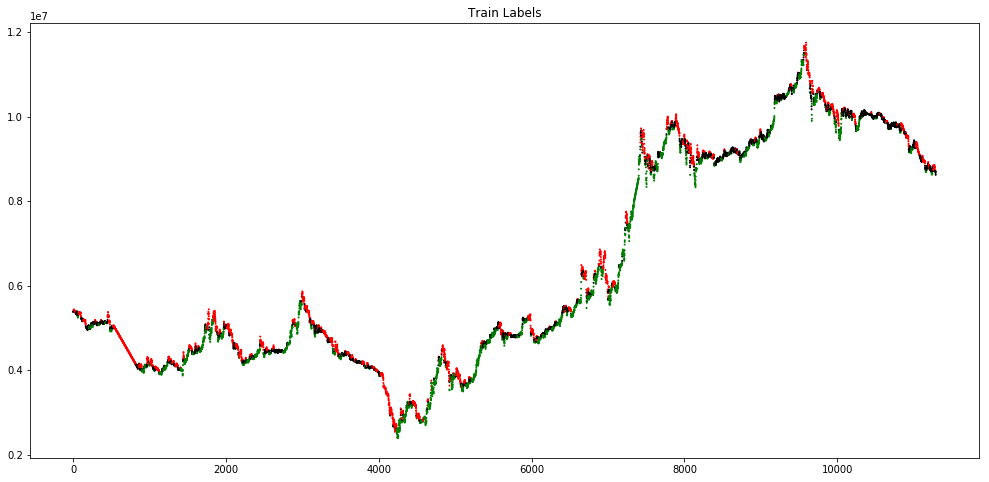

In [180]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(17,8))

ax1.set_title("Train Labels")    
color_label = []
for p in Y_train:  
    if p[1] == 1:
        color = 'green'
    elif p[2] == 1:
        color = 'red' 
    else:
        color = 'black'
    color_label.append(color)

ax1.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=color_label, s=1)

plt.show()

In [181]:

n_time_features = X_train.shape[1]
classes = Y_train.shape[1]
m_test = X_test.shape[0]
m_train = X_train.shape[0]


In [182]:
X_train = X_train.astype(dtype=np.float32)
X_test = X_test.astype(dtype=np.float32)


print(X_train.shape)
print(Y_train.shape)
#print("Y train first  = ")
#print( str(Y_train[0:3,]))

print(X_test.shape)
print(Y_test.shape)

print(" m_train %d, m_test %d, n_features %d, classes %d" % (m_train, m_test, n_time_features, classes ))
  

(11291, 72, 2)
(11291, 3)
(1934, 72, 2)
(1934, 3)
 m_train 11291, m_test 1934, n_features 72, classes 3


# KERAS
The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions 

(N, W, F) where
- N is the number of training sequences, 
- W is the sequence length and 
- F is the number of features of each sequence

network structure of [1, 50, 100, 1] where 
- 1 input layer (consisting of a sequence of size 50) which feeds into an LSTM layer with 50 neurons, 
- that in turn feeds into another LSTM layer with 100 neurons 
- which then feeds into a fully connected normal layer of 1 neuron with a linear activation function which will be used to give the prediction of the next time step.

<img src="images/rnn.jpeg" style="width:600;height:400px;">

In [183]:
#layers = [1, win_size, 100, 1]


data_dim = 2
timesteps = win_size
num_classes = 3

def build_model():
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()

    model.add(
        LSTM(
            120, 
            return_sequences=True,
            input_shape=(timesteps, data_dim),
            dropout=0.2
        )
    )  # returns a sequence of vectors of dimension 32
    
    model.add(LSTM(120, return_sequences=True, dropout=0.2))  # returns a sequence of vectors of dimension 32
    
    model.add(LSTM(120, dropout=0.2))  # return a single vector of dimension 32
    model.add(Dense(num_classes, activation='softmax'))

    start = time.time()
    model.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    #predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [184]:

epochs  = 100

model = build_model()

history = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    nb_epoch=epochs,
    validation_split=0.1)





> Compilation Time :  0.04039406776428223


/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 10161 samples, validate on 1130 samples
Epoch 1/100
10161/10161 [==============================] - 254s 25ms/step - loss: 1.0846 - acc: 0.3989 - val_loss: 1.1226 - val_acc: 0.2301
Epoch 2/100
10161/10161 [==============================] - 267s 26ms/step - loss: 1.0777 - acc: 0.4069 - val_loss: 1.1132 - val_acc: 0.3204
Epoch 3/100
10161/10161 [==============================] - 238s 23ms/step - loss: 1.0734 - acc: 0.4210 - val_loss: 1.0727 - val_acc: 0.3823
Epoch 4/100
10161/10161 [==============================] - 198s 20ms/step - loss: 1.0700 - acc: 0.4172 - val_loss: 1.0664 - val_acc: 0.4327
Epoch 5/100
10161/10161 [==============================] - 198s 20ms/step - loss: 1.0614 - acc: 0.4233 - val_loss: 1.1308 - val_acc: 0.3628
Epoch 6/100
10161/10161 [==============================] - 201s 20ms/step - loss: 1.0533 - acc: 0.4287 - val_loss: 1.1192 - val_acc: 0.4027
Epoch 7/100
10161/10161 [==============================] - 194s 19ms/step - loss: 1.0403 - acc: 0.4413 - val_lo

Epoch 59/100
10161/10161 [==============================] - 193s 19ms/step - loss: 0.4658 - acc: 0.8055 - val_loss: 2.0227 - val_acc: 0.3513
Epoch 60/100
10161/10161 [==============================] - 193s 19ms/step - loss: 0.4812 - acc: 0.7938 - val_loss: 1.9976 - val_acc: 0.3478
Epoch 61/100
10161/10161 [==============================] - 193s 19ms/step - loss: 0.4609 - acc: 0.8058 - val_loss: 1.9302 - val_acc: 0.3637
Epoch 62/100
10161/10161 [==============================] - 194s 19ms/step - loss: 0.4707 - acc: 0.8042 - val_loss: 1.9226 - val_acc: 0.3566
Epoch 63/100
10161/10161 [==============================] - 194s 19ms/step - loss: 0.4569 - acc: 0.8083 - val_loss: 1.8589 - val_acc: 0.3938
Epoch 64/100
10161/10161 [==============================] - 193s 19ms/step - loss: 0.4495 - acc: 0.8146 - val_loss: 1.8580 - val_acc: 0.3832
Epoch 65/100
10161/10161 [==============================] - 193s 19ms/step - loss: 0.4568 - acc: 0.8053 - val_loss: 1.8855 - val_acc: 0.3478
Epoch 66/100


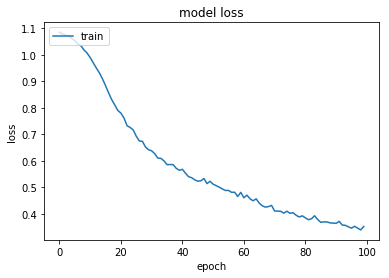

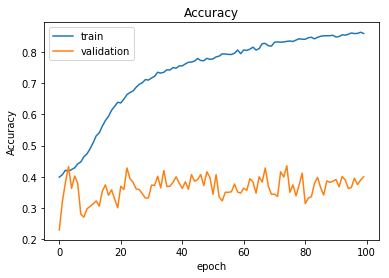

In [185]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [186]:
history.history.keys()

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])

In [187]:
y_predicted_train = predict_point_by_point(model, X_train)
predicted = predict_point_by_point(model, X_test)


In [188]:
np.argmax(y_predicted_train[0,:])
y_predicted_train[0:10,:]

array([[0.86924833, 0.0265574 , 0.10419429],
       [0.80911124, 0.03189289, 0.1589959 ],
       [0.73755705, 0.07658416, 0.1858588 ],
       [0.32781735, 0.04595863, 0.62622404],
       [0.09741067, 0.00925778, 0.8933315 ],
       [0.05200078, 0.00390593, 0.9440933 ],
       [0.05396357, 0.00244985, 0.9435865 ],
       [0.07983091, 0.00141939, 0.9187497 ],
       [0.13240461, 0.00131215, 0.86628324],
       [0.24409902, 0.00243734, 0.7534637 ]], dtype=float32)

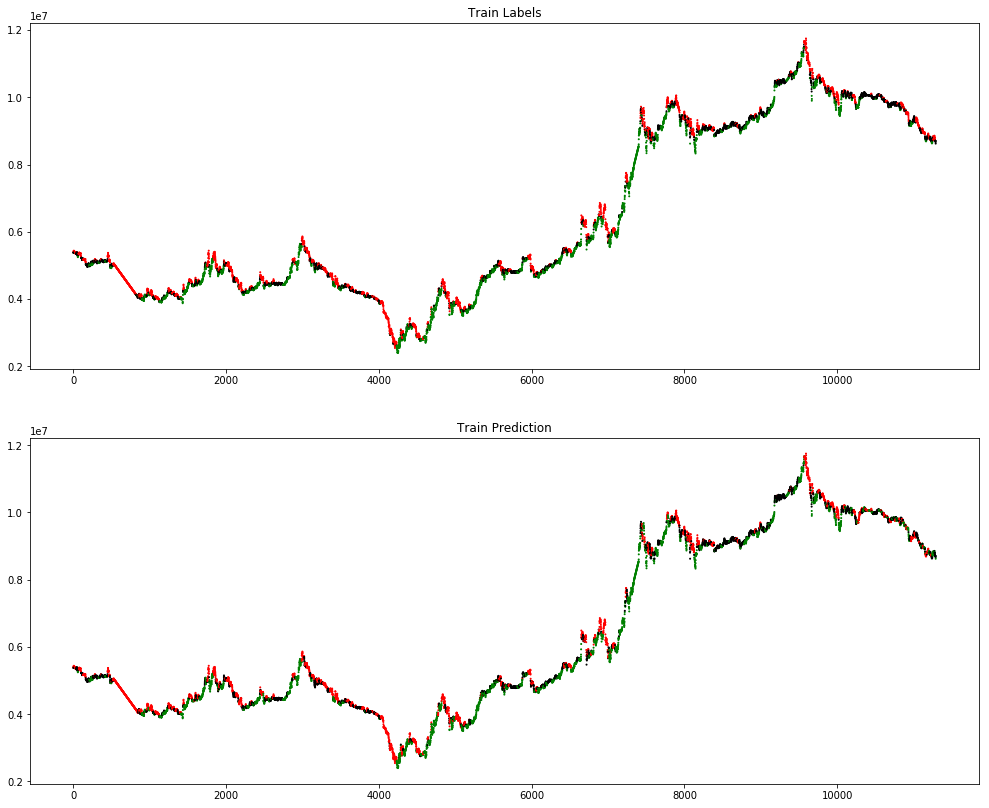

In [189]:
'''
X_train, Y_train, y_tr_price = 
X_test, Y_test, y_tst_price = 
'''

fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(17,14))

ax1.set_title("Train Labels")    
color_label = []
for p in Y_train:  
    if p[1] == 1:
        color = 'green'
    elif p[2] == 1:
        color = 'red' 
    else:
        color = 'black'
    color_label.append(color)
ax1.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=color_label, s=1)

ax2.set_title("Train Prediction")    
col2 = [] 
for p in y_predicted_train: 
    idx = np.argmax(p)
    if idx == 1:
        color = 'green'
    elif idx == 2:
        color = 'red' 
    else:
        color = 'black'
    col2.append(color)

ax2.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=col2, s=1)
plt.show()



In [190]:
predicted[100:200,:]



array([[3.88394343e-03, 9.45279535e-05, 9.96021569e-01],
       [4.03393479e-03, 9.56763251e-05, 9.95870411e-01],
       [4.03081579e-03, 8.60183281e-05, 9.95883226e-01],
       [3.05263000e-03, 6.65994958e-05, 9.96880770e-01],
       [2.00215378e-03, 5.63383728e-05, 9.97941434e-01],
       [3.11626610e-03, 1.40673263e-04, 9.96743143e-01],
       [1.89257553e-03, 9.70385299e-05, 9.98010457e-01],
       [1.21569412e-03, 7.86551318e-05, 9.98705626e-01],
       [1.03279389e-03, 7.12677938e-05, 9.98895884e-01],
       [1.27889006e-03, 9.53978160e-05, 9.98625755e-01],
       [1.70954596e-03, 9.81875419e-05, 9.98192251e-01],
       [6.48602331e-03, 5.11957798e-04, 9.93001997e-01],
       [5.62878810e-02, 6.47785002e-03, 9.37234223e-01],
       [1.21857196e-01, 1.36021562e-02, 8.64540577e-01],
       [1.18080087e-01, 1.23911966e-02, 8.69528711e-01],
       [2.54396982e-02, 1.44396932e-03, 9.73116279e-01],
       [4.92063165e-01, 2.89281830e-02, 4.79008585e-01],
       [2.46404424e-01, 1.80721

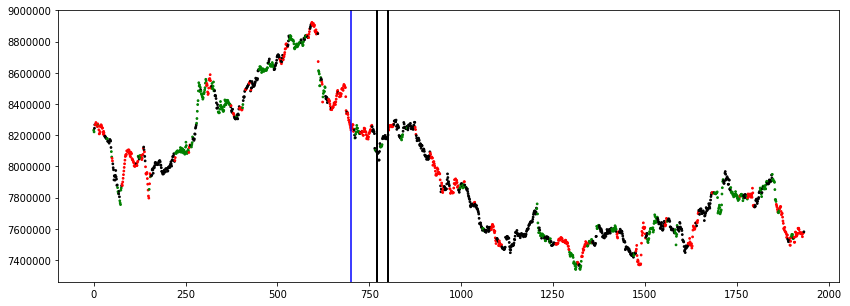

array([6.1498094e-01, 3.8458252e-01, 4.3654715e-04], dtype=float32)

In [208]:
point = 700
start_of_train_position = point
position_on_plot = point + win_size
end_of_future_position = point + win_size + future


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14,5))
col3 = []
for p in predicted: 
    idx = np.argmax(p)
    if idx == 1:
        color = 'green'
    elif idx == 2:
        color = 'red' 
    else:
        color = 'black'
    col3.append(color)


ax1.scatter(range(y_tst_price.shape[0]),  y_tst_price, c=col3, s=3)

ax1.axvline(position_on_plot, color=col3[position_on_plot], lw=2)
ax1.axvline(end_of_future_position, color=col3[position_on_plot], lw=2)
ax1.axvline(start_of_train_position, color='blue')

plt.show()

predicted[position_on_plot,:]

In [ ]:
# add accuracy for predicted plot